In [52]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import PolyCollection
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from scipy.optimize import curve_fit

In [53]:
def process_file(file_name, sort_option = 'none', print_option = False):
    
    df = pd.read_csv(file_name, delimiter='|', header=None, skiprows=1)
    Q = []
    seeds = []
    polygons = []
    data = []

    for index, row in df.iterrows():
        
        # get seedpoints
        seed_data = row[0]
        seed_points = np.array(seed_data.split(','), dtype=float)

        # get polygons for cells
        coords_data = row[1]
        poly = []
        for item in coords_data.split(';'):
            if item:
                points = item.split(",")
                points = np.array(points, dtype=float)
                poly.append(points)
        poly.append(poly[0])

        # get Q value or list of quantities
        q_data = row[2]
        if ',' in str(q_data):
            q_split = np.array(q_data.split(','), dtype=float)
        else:
            q_split = float(q_data)

        data.append((seed_points, poly, q_split))

    # sort data by x or y direction if needed
    if sort_option == 'x':
        data.sort(key=lambda x: x[0][0])
    elif sort_option == 'y':
        data.sort(key=lambda x: x[0][1])

    seeds, polygons, Q = zip(*data)

    if print_option:
        print('processed file')

    return np.array(seeds), list(polygons), np.array(Q)

### 2D-image

In [54]:
# plot mesh with Q
def plot_2D(polygons, Q, cmap = 'viridis', vmin = 0, vmax = 1, edgecolor = 'face', cbar_label = 'Q_value', title = '', save = True, save_name = 'image2D', figsize = (12, 10), logscale = False, logmin = 1e-18):

    if logscale:
        Q = np.log10(np.maximum(Q, np.zeros(len(Q)) + logmin))

    fig, ax = plt.subplots(figsize = figsize)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    collection = PolyCollection(polygons, array=Q, cmap=cmap, norm=norm, edgecolor=edgecolor) # edgecolor = 'none' / 'face'
    print('finished PolyCollection')
    ax.add_collection(collection)
    ax.autoscale_view()
    
    cbar = fig.colorbar(collection, ax=ax)
    cbar.set_label(cbar_label)
    if save:
        plt.savefig('figures/' + save_name + '.png')
    if title != '':
        plt.title(title)
    #plt.show()

### 2D-animation

In [55]:
def animation2D(file_name, frames, fps=30, animation_name='animation2D', cbar_label='Q-value', cmap='viridis', edgecolor='face', vmin=0, vmax=1, title='', lim=(0, 1), figsize=(12, 10), logscale=False, logmin=1e-18):
    
    fig, ax = plt.subplots(figsize=figsize)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    collection = PolyCollection([], array=[], cmap=cmap, norm=norm)
    collection.set_edgecolor(edgecolor)
    ax.add_collection(collection)
    ax.set_xlim(lim[0], lim[1])
    ax.set_ylim(lim[0], lim[1])
    if title != '':
        ax.set_title(title)
    cbar = fig.colorbar(collection, ax=ax)
    cbar.set_label(cbar_label)

    #scatter_plot = ax.scatter([], [], color = 'tab:blue')

    # animation update function
    def update(frame):


        file_path = "files/" + file_name + str(frame) + ".csv"
        seeds, polygons, Q = process_file(file_path)
        Q = Q[:, 1]
        if logscale:
            Q = np.log10(np.maximum(Q, np.zeros(len(Q)) + logmin))
        collection.set_paths(polygons)
        collection.set_array(Q)

        #scatter_plot.set_offsets(seeds)
        
        return collection,

    # progress bar for animation frames
    with tqdm(total=len(frames), desc="Generating Animation") as pbar:
        def wrapped_update(frame):
            result = update(frame)
            pbar.update(1)
            return result

        ani = FuncAnimation(fig, wrapped_update, frames=frames, blit=True, repeat=False)
        ani.save('figures/' + animation_name + '.gif', fps=fps)
    
    plt.show()

Generating Animation: 153it [02:14,  1.14it/s]                         


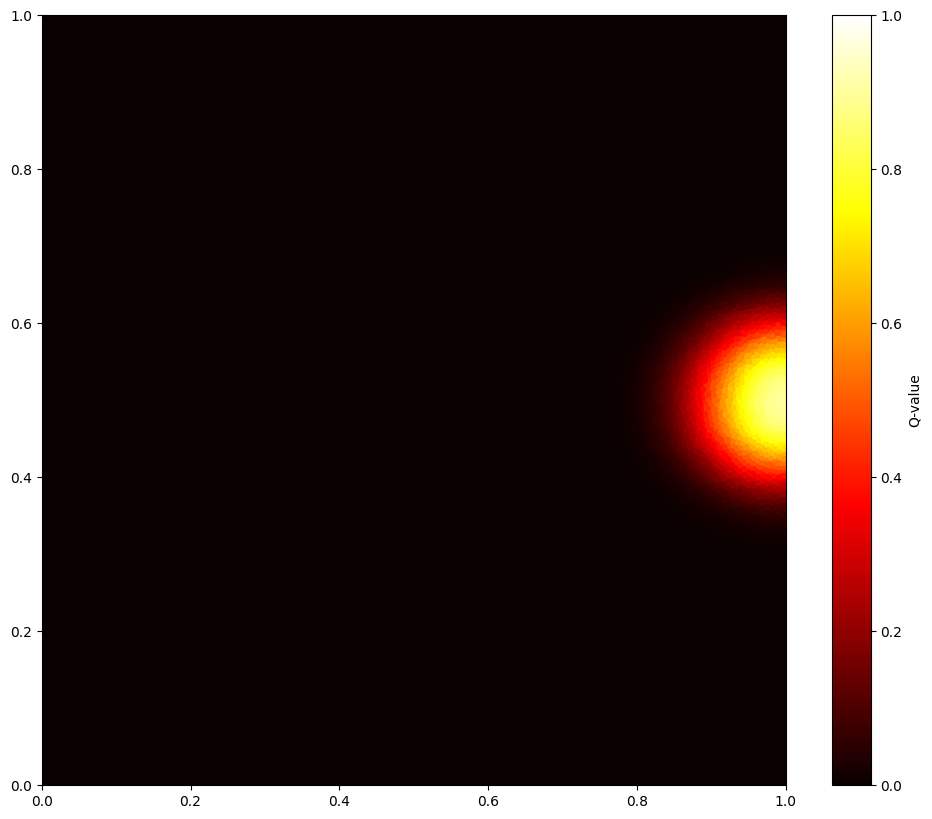

In [63]:
animation2D("vmesh", range(0, 150*9, 9), 30, cmap = 'hot')

### 1D-plot

In [ ]:
# 1D-plot of vmesh and cartesian Q values
def plot_1D(filenames, labels, sort_option, title = '', x_label = '', y_label = 'Q-Value', xlim = (0,1), ylim = (0, 1), save_name = '', bin_size = 0, logscale = False):

    for i in range(len(filenames)):
        seed, polygons, Q = process_file("files/" + filenames[i] + ".csv", sort_option)
        if sort_option == 'y':
            plt.scatter(seed[:, 1], Q[:, 1], marker = '.', label= labels[i])
        elif sort_option == 'x':
            plt.scatter(seed[:, 0], Q[:, 1], marker = '.', label= labels[i])

        if bin_size != 0:
            avg_seed = [np.mean(seed[i:i+bin_size, 1]) for i in range(0, int(len(seed[:, 1])), bin_size)]
            avg_Q = [np.mean(Q[i:i+bin_size, 1]) for i in range(0, int(len(Q[:, 1])), bin_size)]

            plt.plot(avg_seed, avg_Q, label = labels[i] + 'avg', color = 'black')

    if title != '':
        plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    if logscale:
        plt.yscale('log')
    plt.legend()
    if save_name != '':
        plt.savefig("figures/" + save_name + ".png")
    plt.show()

### 1D Animation

In [ ]:
def analytic_Q(x, t, velocity, a, b):

    dx = t * velocity

    if (x > dx + a and x<b+dx):
        return 1
    else:
        return 0

def animation1D(filerange, filenames, labels, sort_option, fps = 30, title = '', x_label = '', y_label = 'Q-Value', xlim = (0,1), ylim = (0, 1), save_name = 'animation1D', bin_size = 0, analytic_solution = False, velocity = 0.5, a = 0, b = 0.1):
    
    def update1D(frame):

        plt.cla()
        for i in range(len(filenames)):
            seed, polygons, Q = process_file("files/" + filenames[i] + str(frame) + ".csv", sort_option)

            if sort_option == 'y':
                plt.scatter(seed[:, 1], Q[:, 1], marker = '.', label= labels[i])
            elif sort_option == 'x':
                plt.scatter(seed[:, 0], Q[:, 1], marker = '.', label= labels[i])

            if bin_size != 0:
                avg_seed = [np.mean(seed[i:i+bin_size, 1]) for i in range(0, int(len(seed[:, 1])), bin_size)]
                avg_Q = [np.mean(Q[i:i+bin_size, 1]) for i in range(0, int(len(Q[:, 1])), bin_size)]

                plt.plot(avg_seed, avg_Q, label = labels[i] + '_avg', color = 'black')
        
            if analytic_solution:
                lsp = np.linspace(xlim[0], xlim[1], 1000)
                Q_analytic = [analytic_Q(x, Q[0, 0], velocity, a, b) for x in lsp]
                plt.plot(lsp, Q_analytic, label = labels[i] + '_analytic', color = 'red')

        if title != '':
            plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.legend(loc = 'upper right')

    fig, ax = plt.subplots()

    with tqdm(total=len(filerange), desc='Generating Animation') as pbar:
        def update_and_progress(frame):
            update1D(frame)
            pbar.update(1)
    
        ani = FuncAnimation(fig, update_and_progress, frames=filerange, repeat=True)
        ani.save('figures/' + save_name + '.gif', fps=fps)
        plt.show()   

### L1 Error Plots

In [60]:
def plot_L1_error_over_time(filenames = ["L1_error"], labels = ["L1_error"], title = 'L1 error over time', xlabel = "time in [a.u]", ylabel = 'L1 error', save_name = 'L1_over_time'):
    
    for i in range(len(filenames)):

        df = pd.read_csv('files/' + filenames[i] + '.csv', decimal = ',', header=None)
        time = df[0].astype(float).values
        L1 = df[1].astype(float).values
        plt.plot(time, L1, label = labels[i])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(0.8, color = "black")
    plt.legend()
    plt.savefig("figures/"+ save_name +".png")
    plt.show() 

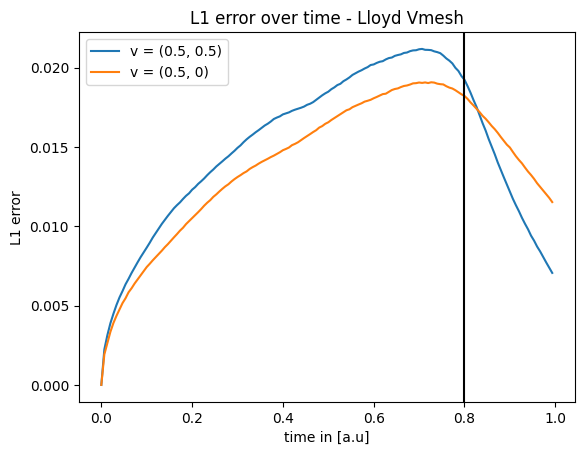

In [64]:
plot_L1_error_over_time(["L1_error_upright_vmesh_lloyd", "L1_error_right_vmesh_lloyd"], ["v = (0.5, 0.5)", "v = (0.5, 0)"], title = "L1 error over time - Lloyd Vmesh")

In [ ]:
def fit_function(x, a, b):
    return a/np.sqrt(b * x)

def plot_L1_error_over_N(filenames, N_list, index = -1):

    L1s = []

    for i in range(len(filenames)):
        df = pd.read_csv('files/' + filenames[i] + '.csv', decimal = ',', header=None)
        L1 = df[1].astype(float).values
        L1s.append(L1[index])

    popt, pcov = curve_fit(fit_function, N_list, L1s)
    lsp = np.linspace(min(N_list), max(N_list), 10)
    plt.plot(lsp, fit_function(lsp, *popt), label = 'f(x) = 1/sqrt(x)', color = 'grey')
    plt.scatter(N_list, L1s, marker = 'o', label = 'L1-error')
    plt.title("L1 error over resolution - Vmesh Circle")
    plt.xlabel("N_x")
    plt.ylabel("L1 error")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig("figures/L1_error_over_N.png")
    plt.show() 

### Q difference Plots

In [ ]:
# plot difference in total Q over time
def plot_Q_diff_over_time(filename = 'total_Q_diff', logscale = True, title = 'Change in total Q over time', xlabel = "time in [a.u]", ylabel = '|total_Q - total_Q_initial|', save_name = 'delta_Q_total', bar = 0):

    df = pd.read_csv('files/' + filename + '.csv', decimal=',', header=None)
    times = df[0].astype(float).values
    diff_Q = df[1].astype(float).values

    plt.plot(times, np.abs(diff_Q))
    if logscale:
        plt.yscale('log')
    plt.title(title)
    if bar != 0:
        plt.axvline(bar, color = 'tab:orange')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig("figures/"+ save_name +".png")
    plt.show()    